# 1. Inverse filter design and implementation

The first step in the signal processing for the device is to **implement a filter that allow us to correct the microphone's characteristic response**. Since we assume that we are dealing with an **LTI system** (linear and time-invariant system), the idea is to obtain the frequency response of the microphone in order to then design a **filter based on the inverse system**.

**By applying this inverse response, we would then linearize the system response**. So first thing first, we need the system response, for that we've made a measurement in a semi-anechoic room where we compared and average the **response of our system** (henceforth the **device under test or DUT**) with that of a system that is consider to be **linear in the frequency interval of interest**. This is comprised of an **Earthworks M50 ominidirectional measurement microphone** and a **RME Fireface audio interface**. 

Calculating the **transfer function between both systems** we can get rid of the undesired effects of the room, the background noise, and the sound source (among others), since we assume that an approximate equal signal incides on both transducers. So we would finally get the **desired system's frequency response**.

The basic block diagram of the measurement is as follows:

![img](../img/freq_resp.jpg)

## Explain

In [7]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

fs, dut_1 = wavfile.read('../aud/ir/dut1.wav')
_, dut_2 = wavfile.read('../aud/ir/dut2.wav')
_, ref_1 = wavfile.read('../aud/ir/ref1.wav')
_, ref_2 = wavfile.read('../aud/ir/ref2.wav')

## explain

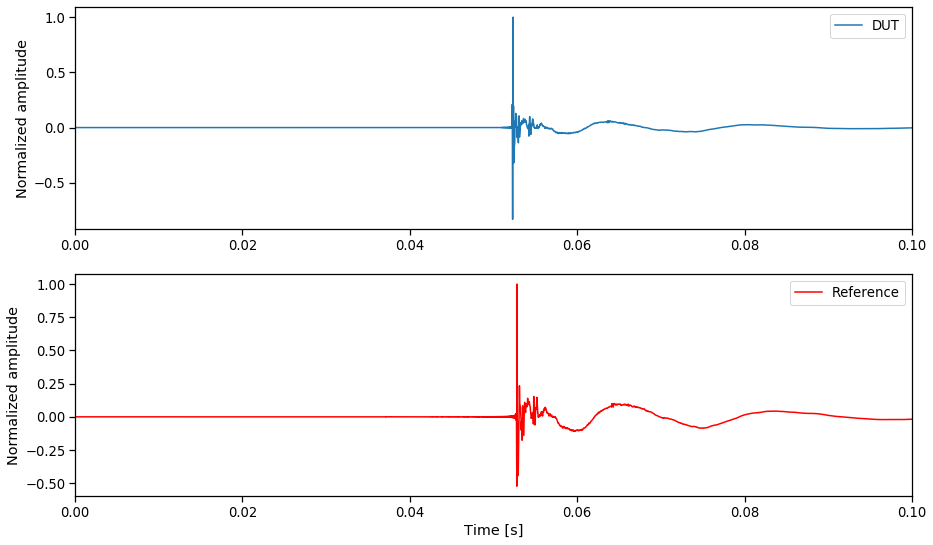

In [8]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(np.arange(len(dut_1))/fs, dut_1/max(dut_1), label='DUT')
ax[1].plot(np.arange(len(ref_1))/fs, ref_1/max(ref_1), 'r', label='Reference')

ax[0].set_xlim([0, 0.10])
ax[1].set_xlim([0, 0.10])

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Normalized amplitude')
ax[1].set_ylabel('Normalized amplitude');

## explain

In [10]:
def spec(x, nfft=2**16, window='rect'):
    """ Compute the FFT spectrum of the input audio signal 'x'. 
    The number of points for which to compute the FFT can be 
    specified by 'nfft'. Its possible to select a Hanning or Flattop
    window, in which case corrections are applied to obtain accurate 
    measurements based on the spectrum. """
    freq = fs/2*np.linspace(0, 1, int(nfft/2)+1)  # FFT frequency vector
    if window == 'hann':
        window = np.hanning(len(x))  # Hann window
        CPG = 6.02 # Coherent Power Gain [dB]
        data = x*window
    elif window == 'flat':
        window = flattop(len(x))  # flattop window
        CPG = 13.3 # Coherent Power Gain [dB]
        data = x*window
    else:
        data = x
    sp = np.fft.rfft(data, nfft)
    spp = np.abs(sp)/nfft
    return spp, freq

def ref_f(x, f):
    """ References the input signal 'x' at 1 kHz according
    to the frequency array 'f'. """
    idx = (np.abs(f-1000)).argmin()
    return x-x[idx]

def fft_average(x, nfft=2**16):
    """ Receives a tuple or list of audio arrays 'x', calculates and 
    normalizes the FFT spectrum of each of them and returns their average. 
    With 'nfft' the number of FFT points can be modified. """
    X = np.empty([len(x), int(nfft/2+1)])
    xn = np.empty([len(x), int(nfft/2+1)])
    y = np.empty(int(nfft/2))
    for i in range(len(x)):
        X[i,:], freq = spec(x[i], nfft=nfft)
        xn[i,:] = 1 + ref_f(X[i,:], freq)
    y = np.apply_along_axis(np.mean, 0, xn)
    return y, freq

Having specified the functions needed to compute and average the spectrum of both systems we'll apply those and we'll be ready to calculate the transfer function between them.

In [15]:
dut_avg, freq = fft_average([dut_1, dut_2])
ref_avg, _ = fft_average([ref_1, ref_2])

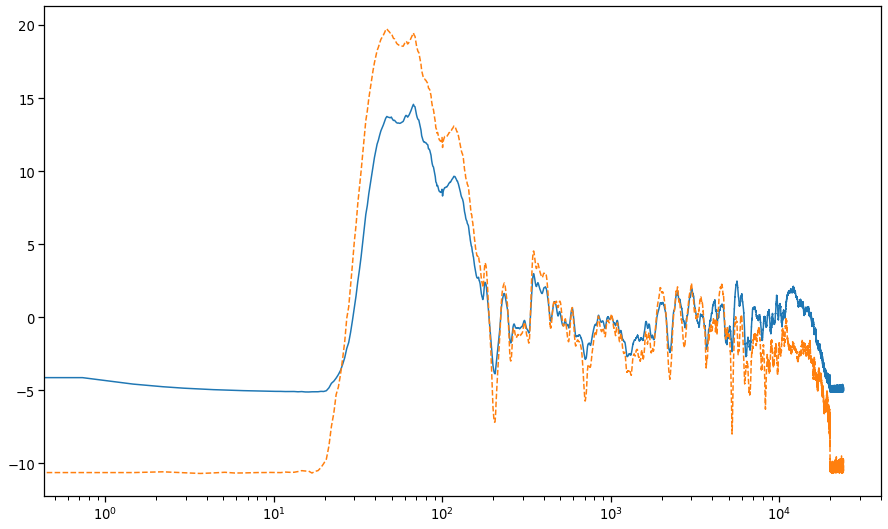

In [176]:
plt.semilogx(freq, 20*np.log10(dut_avg))
plt.semilogx(freq, 20*np.log10(ref_avg), '--')

(20, 20000)

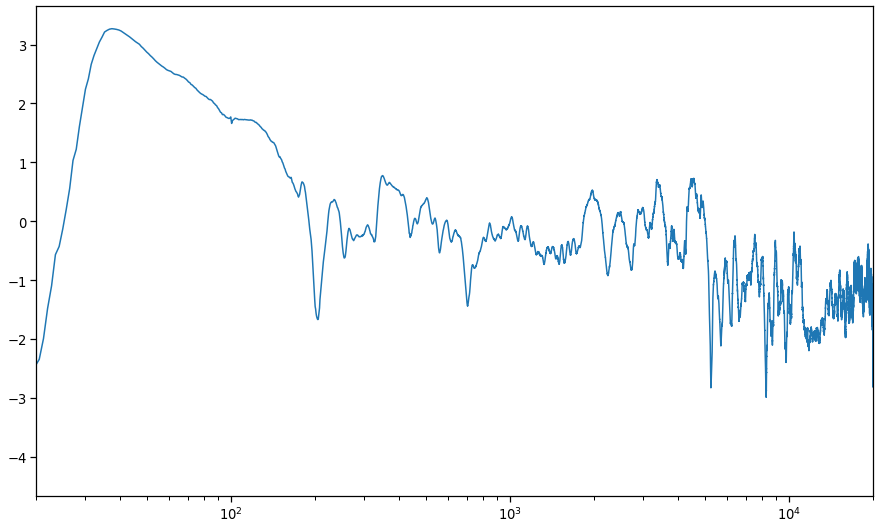

In [392]:
plt.semilogx(freq, 10*np.log10(ref_avg/dut_avg))
plt.xlim([20, 20000])

In [406]:
inv = ref_f(10*np.log10(ref_avg/dut_avg), freq)

inv_reg = F_inv.copy()
inv_reg[np.where((freq < 10) | (freq > 40000))[0]] = 0

In [407]:
def smooth_spectrum(X, freq, Noct=3):
    """ Apply a 1/Noct smoothing to the input frequency spectrum 'X'
    at the 'freq' frequencies.
    Calculates the i-th smoothed spectral coefficient 'X_oct(i)' as 
    the sum of the windowed spectrum. The window is a Gaussian whose
    center frequency is 'freq(i)', and whose sigma is proportional
    to 'freq(i)/Noct'. """
    # initial spectrum
    X_oct = X.copy()
    if Noct > 0:
        for i in np.arange(np.where(freq>0)[0][0], len(freq)):
            g = gauss_f(freq=freq, f0=freq[i], Noct=Noct)
            X_oct[i] = sum(g*X)
    # avoid undershoot
    if min(X) >= 0:
        X_oct[X_oct<0] = 0
    return X_oct

def gauss_f(freq, f0, Noct):
    """ Calculate frequency-domain Gaussian with unity gain. 
    Inputs:
    freq: array of frequencies in which to do the computation.
    f_0: center frequency.
    Noct: determines the bandwith as f_0/Noct. """
    # standard deviation
    sigma = (f0/Noct)/np.pi
    # Gaussian
    g = np.exp(-(((freq-f0)**2)/(2*(sigma**2))))
    # magnitude normalizaition
    return g/sum(g)

In [408]:
F_inv = smooth_spectrum(inv_reg, freq, Noct=3)

(20, 20000)

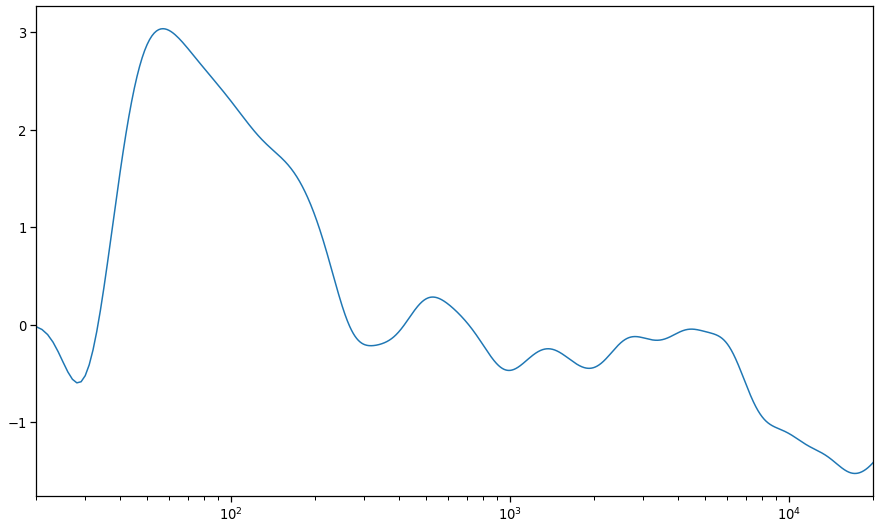

In [409]:
plt.semilogx(F_inv)

plt.xlim([20, 20000])

plt.semilogx(F_inv)

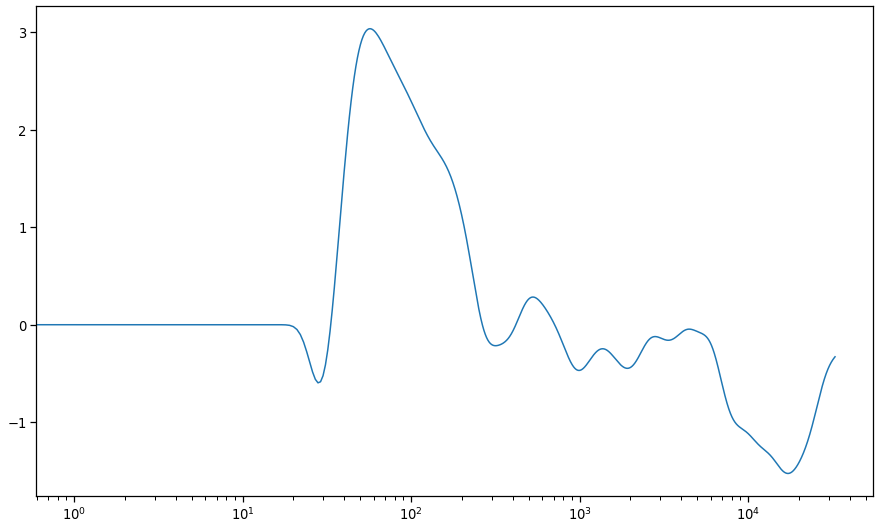

In [410]:
plt.semilogx(F_inv)